# ArcGIS GeoAnalytics for Microsoft Fabric: Spatial operations and properties

In this notebook, we will explore the fundamentals of working with spatial data in ArcGIS GeoAnalytics for Microsoft Fabric. We will showcase spatial data engineering processes such as creating geometry, working with coordinate systems, and calculating and updating spatial properties in your data. Upon completion of this guide, you will possess a solid comprehension of using [ArcGIS GeoAnalytics](https://developers.arcgis.com/geoanalytics-fabric/) for manipulating spatial data and calculating spatial properties.  Let's begin!
 



***Public Preview notes*** 
* ArcGIS GeoAnalytics is enabled in the Fabric Runtime 1.3 only

* In the ArcGIS GeoAnalytics _Public Preview_, to render base map tiles when plotting maps using the [st.plot](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#plot) functionality, you will need to run the following configuration cell when starting your computing environment.  Note that using the configuration will lead to a slower startup for the computing environment.  This is not necessary if you do not require the base map tiles in your map.  Spatial data in your DataFrame will still render, however you will not have the base map tiles in the background. 

In [1]:
%%configure -f
{    
    "conf":    
    {   
        "spark.driver.extraJavaOptions" : "--add-opens java.base/jdk.internal.loader=ALL-UNNAMED",
        "spark.jars.packages": "com.google.protobuf:protobuf-java:3.25.5"    
    }
}

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, -1, Finished, Available, Finished)

## Add a Lakehouse
***There is only one segment of this tutorial that writes data to the Lakehouse.  If you do not want to create a Lakehouse for this tutorial, you do not need to.  You can skip this section and skip the cell later in the tutorial that demonstrates writing results to the Lakehouse***

The Fabric Lakehouse is a location where you can store and manage your data.  To work with data within your Fabric environment, you will need to connect to a Lakehouse that houses the data.  

Your Lakehouse must be connected before you start your computing session.

To connect to a Lakehouse, click on ```Lakehouses``` in the Explorer pane and ```Add Lakehouse```

You can add an existing Lakehouse, or create a new one for this tutorial.  

For more information, refer to ["What is a lakehouse in Microsoft Fabric?"](https://learn.microsoft.com/en-us/fabric/data-engineering/lakehouse-overview)


## Import ArcGIS GeoAnalytics
To work with ArcGIS GeoAnalytics for Microsoft Fabric, you need to import it in your notebook.  The library is named ```geoanalytics_fabric```

This imports the library at the top level.  To make the functionality easier to access, we recommend also importing the [geospatial functions](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/) directly, and to give them an easy to use alias for reference.  In the example below, we import the library and the functions with an alias of ```ST```.  Since each of the functions are named ST.\<function_name\> this makes them easy to reference and identifies them as being Spatial Type (ST) functions.  This will also align with the structure of examples throughout the ArcGIS GeoAnalytics documentation.


For instance, after importing, you would be able to reference the [ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/) function using ```ST.buffer``` instead of ```geoanalytics_fabric.sql.functions.buffer```

See the [developer documentation](https://developers.arcgis.com/geoanalytics-fabric/) for more information about the functions available in ArcGIS GeoAnalytics.


In [3]:
# import ArcGIS GeoAnalytics
import geoanalytics_fabric
import geoanalytics_fabric.sql.functions as ST
import pyspark.sql.functions as F

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 4, Finished, Available, Finished)

## Ingest data 

For this sample notebook, we will use a dataset of [public safety data from the city of Boston, MA](https://learn.microsoft.com/en-us/azure/open-datasets/dataset-boston-safety) from the [Azure open datasets](https://azure.microsoft.com/en-us/products/open-datasets).  

This dataset is in a parquet format and contains latitude and longitude coordinates for each record.

To read the data, we can use the code sample provided on the Azure open dataset page for working with PySpark in Azure Synapse.  



In [4]:
# https://learn.microsoft.com/en-us/azure/open-datasets/dataset-boston-safety?tabs=pyspark
# Azure storage access info
blob_account_name = "azureopendatastorage"
blob_container_name = "citydatacontainer"
blob_relative_path = "Safety/Release/city=Boston"
blob_sas_token = r""

# Allow SPARK to read from Blob remotely
wasbs_path = 'wasbs://%s@%s.blob.core.windows.net/%s' % (blob_container_name, blob_account_name, blob_relative_path)
spark.conf.set(
  'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
  blob_sas_token)
print('Remote blob path: ' + wasbs_path)

# SPARK read parquet
df = spark.read.parquet(wasbs_path)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 5, Finished, Available, Finished)

Remote blob path: wasbs://citydatacontainer@azureopendatastorage.blob.core.windows.net/Safety/Release/city=Boston


In [5]:
df.printSchema()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 6, Finished, Available, Finished)

root
 |-- dataType: string (nullable = true)
 |-- dataSubtype: string (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- status: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- source: string (nullable = true)
 |-- extendedProperties: string (nullable = true)



### Clean up invalid latitude and longitude values

An important first step in working with spatial data is to look for incorrect or erroneous geometries. 

The dataset in this notebook happens to have some incorrect / out-of-expected range values for the service call location coordinates.
We'll go ahead and identify those and clean them out before we start working with the data further.

From looking the range of values for latitude and longitude using PySpark [describe()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.describe.html), we can see that there are values outside the range of what would be expected for Boston (latitude of ~42.33, and longitude of ~-71.07).  


In [6]:
# Use describe() to look at the range of values for latitude and longitude
# The city of Boston is centered at a latitude of: ~42.33, and a longitude of: ~-71.07
# The values shown below suggest that we have some latitude and longitude values that are erroneous 
# These might be that the entries were swapped or due to typos
df.select("latitude", "longitude").describe().show()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 7, Finished, Available, Finished)

+-------+-------------------+------------------+
|summary|           latitude|         longitude|
+-------+-------------------+------------------+
|  count|            2416538|           2416538|
|   mean|  42.32541813203023|-71.08340896253915|
| stddev|0.24557136772116778|0.2668960195100962|
|    min| -71.13580999993192| -71.1906604328631|
|    max| 42.398986182218465|42.393246999947344|
+-------+-------------------+------------------+



We can clean those values out by filtering to just the latitude and longitude values that are in the expected range.

In [7]:
def clean_data(df):
    # Filter rows based on columns: 'latitude', 'longitude'
    df = df.filter((df['latitude'] > 42) &  (df['longitude'] < -70.1))
    return df

df = clean_data(df)


StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 8, Finished, Available, Finished)

In [8]:
# check the ranges of values again to confirm they seem more in line with what is expected for Boston
df.select("latitude", "longitude").describe().show()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 9, Finished, Available, Finished)

+-------+-------------------+-------------------+
|summary|           latitude|          longitude|
+-------+-------------------+-------------------+
|  count|            2416520|            2416520|
|   mean|  42.32602760670099| -71.08411357812946|
| stddev|0.03376846471885641|0.03585885843926397|
|    min| 42.227655715873446|  -71.1906604328631|
|    max| 42.398986182218465| -70.95756038595339|
+-------+-------------------+-------------------+



### Examine the data to see what is included
We can display the DataFrame that we read in to better understand what is in the data.  

In this case, we have some input that is geographic (latitude and longitude coordinates), but no actual geometry column.  If you look at the schema, there is no point geometry yet.

We will create geometries as we explore the spatial functions in ArcGIS GeoAnalytics.



In [9]:
# print the schema for the table
df.printSchema()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 10, Finished, Available, Finished)

root
 |-- dataType: string (nullable = true)
 |-- dataSubtype: string (nullable = true)
 |-- dateTime: timestamp (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- status: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- source: string (nullable = true)
 |-- extendedProperties: string (nullable = true)



In [10]:
# display the table
display(df)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 94d1c855-5558-486a-b7ab-95ce1bfba53a)

## Spatial functions in ArcGIS GeoAnalytics for Microsoft Fabric

There are more than 160 spatial functions in ArcGIS GeoAnalytics .  They are all documented in the [ArcGIS GeoAnalytics developers guide](https://developers.arcgis.com/geoanalytics-fabric/). 

In this section of the lesson, we will walk through the most common functions and how to use them.

### Data constructors

The ArcGIS GeoAnalytics library contains a set of data constructor functions for creating or converting geometry.  These are useful for ingesting data and transforming it into a geometry.

There are five spatial formats supported. Each of these has a function for creating geometry from the text or binary representation (```ST_GeomFrom\{spatial type\}```), and for converting geometry to this text or binary representation (```ST_As\{spatial type\}```). You can ingest data and convert between geometry types using the functions for these spatial formats.  Below we list the generic "geometry" form for each format, however, each also has associated functions to support reading in specific geometry types (Point, Line, and Polygon), for instance ```ST_PointFromBinary``` is the Point-specific format of ```ST_GeomFromBinary```. 
* Binary 
    * [ST_GeomFromBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_binary/)
    * [ST_AsBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_binary/)
* Text (Well-known text) 
    * [ST_GeomFromText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_text/)
    * [ST_AsText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_text/)
* GeoJSON 
    * [ST_GeomFromGeoJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_geojson/)
    * [ST_AsGeoJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_geojson/)
* EsriJSON 
    * [ST_GeomFromEsriJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_esri_json/)
    * [ST_AsEsriJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_esri_json/)
* Shape (Shapefile) 
    * [ST_GeomFromShape](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_shape/)
    * [ST_AsShape](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_shape/)






There are also constructors for generating geometry from x,y coordinates or arrays of points:
* [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/)
* [ST_MultiPoint](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_multipoint/)
* [ST_LineString](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_linestring/)
* [ST_MultiLineString](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_multilinestring/)
* [ST_Polygon](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_polygon/)
* [ST_MultiPolygon](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_multipolygon/)


#### Create geometry from point coordinates

By default, this dataset that we imported doesn't have any geometry, but it does have latitude and longitude coordinates for each record.  To work with any data using ArcGIS GeoAnalytics, if there isn't already at least one geometry column, we will start by creating a geometry.  

Depending on the format of the data, there are a number of functions included with GeoAnalytics for Fabric that can be used.  Since this dataset has point coordinates in two separate columns, we will use [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/).

[ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/) takes two numeric columns or double values as input and returns a point column. The two numeric columns or values must contain the x,y coordinates of the point geometries. You can optionally specify a spatial reference for the result point column.  In the example below, we add the spatial reference identifier of 4326.  This indicates that the coordinates use the [World Geodetic System 1984 coordinate system](https://en.wikipedia.org/wiki/World_Geodetic_System), or WGS84

You can find more information about coordinate systems and spatial reference identifiers in the GeoAnalytics for Microsoft Fabric core concepts on [Coordinate systems and transformations](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/)

Note that the ordering of the coordinates used as input for [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/) is _(longitude, latitude)_ or _(x,y)_.


In [11]:
# create a new column called geometry for each record
# when we create the point geometries here, we are adding an optional value for the spatial reference. In this case it is 4326 (the World Geodetic Survey of 1984, or WGS84)
df = df\
    .withColumn("geometry", ST.point("Longitude", "Latitude", 4326))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 12, Finished, Available, Finished)

When displaying tables with a geometry, the point, line, or polygon geometry is automatically converted into a more human-readable format for display.  

Take a look at the point geometry as listed in new `geometry` column.

In [12]:
# display select attributes with the input coordinates and point geometry columns of data
display(
    df.select("category", "subcategory", "status", "address", "latitude", "longitude", "geometry")
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6aefb760-1376-410b-b043-d750f5b9ca05)

Now we have a geometry field to work with, we can start to explore the spatial functions available with the GeoAnalytics for Microsoft Fabric library

#### Converting between geometry types

To demonstrate the process of converting between geometry types, we can translate our point geometry between the different formats supported.

In the example below we will just do the conversions for _display_ so that we can see the differences, but won't create new columns with the converted geometry

The GeoJSON, EsriJSON, and well-known text formats are all human-readable representations of the geometry.

The well-known binary and shapefile representations are not.

In [13]:
# show the results of converting a geometry to binary, geoJSON, esriJSON, text, and shape formats
display(
    df.select("geometry",
          ST.as_binary("geometry").alias("geom_binary"),
          ST.as_geojson("geometry").alias("geom_geojson"),
          ST.as_esri_json("geometry").alias("geom_esrijson"),
          ST.as_text("geometry").alias("geom_text"),
          ST.as_shape("geometry").alias("geom_shape"))
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 14, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 321d0e9c-81c8-4312-ae41-1301ac434ce9)

#### When and why would you convert between geometry types?
When working with geometry using the GeoAnalytics in Microsoft Fabric library, you will primarily work with the native geometry format.  This is what you end up with when you read a spatial file directly into a DataFrame (e.g., from a shapefile, feature service, or geodatabase) or convert using any of the ST_GeomFrom\{spatial type\} functions. 

However, the geometry format that the GeoAnalytics library uses isn't recognized _everywhere_ and you might need to use a different format when you save your data back into OneLake or into another storage location.  

For example, if you want to save the results of spatial analysis back to OneLake in a Delta format, we recommend you first convert your geometries into a text or binary representation.  Well-known binary is generally the most compact representation, however, it isn't human-readable.  If you need a human-readable format, well-known text is another option.

You can convert your data into one of those formats with the [ST_AsBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_binary/) or [ST_AsText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_text/) functions.

Let's look at an example of writing a Delta table and converting the point geometries.


***This step is optional; not required to complete running the notebook***

In the example below, we write a subset of attributes as a Delta table.

If you want to explore writing the data results, you can un-comment the cell below and run it.  To write the data, you will need to have a lakehouse attached to the notebook. 

In [14]:
# # Write a delta file with well-known binary geometry
# df\
#     .withColumn("geometry_wkb", ST.as_binary("geometry"))\
#     .write\
#     .mode("overwrite")\
#     .option("overwriteSchema", True)\
#     .format("delta")\
#     .save("Tables/service_calls_delta")

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 15, Finished, Available, Finished)

### Identifying and updating the spatial reference 

A spatial reference describes where features are located in the world. Most spatial references are either geographic (using a geographic coordinate system, i.e., latitude and longitude) or projected (using a projected coordinate system).

More information about spatial reference, coordinate systems, and transformations can be found in the [core concepts for ArcGIS GeoAnalytics](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/).

#### Identify the spatial reference system

If there is a spatial reference system defined for your data, you can check this information using the [ST_SRID](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_srid/) function or [get_spatial_reference()](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#get-spatial-reference).

In the examples below, the result should show that the spatial reference is "4326."  4326 is the identifier for WGS84. For more details on spatial reference IDs, they can be looked up on the [spatialreference.org](https://spatialreference.org/) website.  For example, here is the entry for [WGS84](https://spatialreference.org/ref/epsg/4326/)

In [15]:
# check the spatial reference ID (SRID) for each row in a DataFrame
display(df.select("geometry", ST.srid("geometry").alias("SRID")))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 323bba1f-6f7f-4dbf-a616-892ad652f263)

In [16]:
# retrieve detailed spatial reference information for a geometry column in a DataFrame
# if there is only one geometry column in the dataset, you do not need to specify the column
sr = df.st.get_spatial_reference("geometry")
print("SRID:", sr.srid)
print("Is Projected:", sr.is_projected)
print("Unit:", sr.unit)
print("WKT:", sr.wkt)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 17, Finished, Available, Finished)

SRID: 4326
Is Projected: False
Unit: Degree
WKT: GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]


#### Transform spatial reference

If you have a spatial reference set for your geometry, you can transform it into a different spatial reference using [ST_Transform](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_transform/) and specifying the spatial reference ID (SRID) or provide a valid [Well-Known Text (WKT) string](https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems) for the new spatial reference.

For some GeoAnalytics functions and tools you can perform your analysis without transforming the data between different coordinate systems, as the GeoAnalytics library will project on the fly, as needed.  However, when calculating spatial properties (e.g., area, distance, etc.) the unit of measure is generally the unit of the input geometry.  If the geometry is in a geographic coordinate system then your results will likely be in decimal degrees, which are angular units.  You should work in a projected coordinate system to get results in meters or other planar linear units.  We recommend always reading the documentation to ensure you understand the spatial units of your dataset and the units that will result from various analysis functions / tools. Additional information regarding coordinate systems and transformations can be found in the GeoAnalytics for Fabric core concept on [coordinate systems and transformations](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/).

For many calculations of geographic properties there are also options for using geodesic calculations, which take the curvature of the Earth into account and result in accurate linear distance measurements (in meters).

In the example below, we will transform the geometry from WGS84 (SRID 4326) to Massachusetts State Plane Coordinate System (SRID 2249).  This is an example of transforming a geographic coordinate system to a projected coordinate system.  The units of the Massachusetts State Plane Coordinate system are feet, so measurements of distance on this projected data will be in feet.  Note that in this example below we are just transforming the geometry and displaying the result in a table.  


In [17]:
# Transform geometry using ST_transform and check the SRID values
display(df
    .select(
        "geometry",
        ST.srid("geometry").alias("geometry_srid"),
        ST.transform("geometry", 2249).alias("geometry_2249"),
        ST.srid("geometry_2249").alias("geometry_2249_srid"),
    )
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 18, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 13f3631d-5713-45b8-bef3-2ea5cb889c5b)

If we wanted to transform the geometry in the table, we would update the column of data with the transformed values.  Here is an example:

In [18]:
# update a DataFrame with a transformed geometry
df = df\
    .withColumn("geometry", ST.transform("geometry", 2249))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 19, Finished, Available, Finished)

In [19]:
# check the values for the updated geometry
# coordinates should now be in Massachusetts State Plane (SRID 2249) coordinates (feet) instead of latitude and longitude
display(df.select("geometry", ST.srid("geometry")))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 20, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4fef58c9-2097-4266-9884-09e7a0bcdff6)

### Calculating new geometries

The GeoAnalytics library contains a set of spatial operations for generating new geometries based on the input.  For instance, we will explore a few common functions here:

* [ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/) & [ST_GeodesicBuffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_buffer/) - creates a polygon representing the area less than or equal to the distance specified around the input geometry (e.g., the region within 10 kilometers around a point)
* [ST_HexBin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_hex_bin/), [ST_H3Bin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_h3_bin/), or [ST_SquareBin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_square_bin/) - aggregate data into polygon bins 
* [ST_ShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_shortest_line/) & [ST_GeodesicShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_shortest_line/) - creates a line geometry representing the shortest line between two input geometries



While this section will explore a few functions in detail, there are many more in the GeoAnalytics library that may be of interest for your analytics projects.  You can explore the range of functions in the [documentation of SQL Functions](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/).

We will use the public service requests  that we read in earlier and transform those points into a variety of new geometries.

#### ST_Buffer & ST_GeodesicBuffer

[ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/) and [ST_GeodesicBuffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_buffer/) create polygons representing the area less than or equal to the distance specified around the input geometry (e.g., the region within 10 miles around a point).  These functions will create this buffer around every entity in the geometry column.  

To see how this works, we'll start by creating a new DataFrame with a few school locations in the Boston area.  We will buffer those to visually look at the public service requests near to each school.

In [20]:
# create a DataFrame with locations of several schools (in latitude and longitude)
df_schools = spark.createDataFrame([
    (-71.0777, 42.3388, "Hurley K-8"),
    (-71.0919,42.3176, "Higginson Elementary School"),
    (-71.1016, 42.3164, "Mendell Elementary School")], ["longitude", "latitude", "name"])

# create a point geometry column ("geometry") from the latitude and longitude values
df_schools = df_schools\
    .withColumn("geometry", ST.point("longitude", "latitude", sr=4326))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 21, Finished, Available, Finished)

Now we can create buffers around these schools.

The distance unit for the buffer is in the same units as the input geometry.  For example, if the data is in the web Mercator coordinate system, the units will be meters; if your data is in a geographic coordinate system, the units will be decimal degrees.  

The [ST_GeodesicBuffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_buffer/) function can be used to create buffers using geodesic distance in meters.

In [21]:
# create example buffers using ST_Buffer and ST_GeodesicBuffer
# This example generates a buffer of 0.5 _decimal degrees_ (the units for the input data are latitude/longitude values!)
# It also created a geodesic buffer of 500 meters
df_schools = df_schools\
    .withColumn("geometry_buffer", ST.buffer("geometry", 0.5))\
    .withColumn("geometry_geodesic_buffer", ST.geodesic_buffer("geometry", 500))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 22, Finished, Available, Finished)

Let's take a look at the two buffers (geodesic vs. regular buffer) and how they differ.  

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 23, Finished, Available, Finished)

<Axes: >

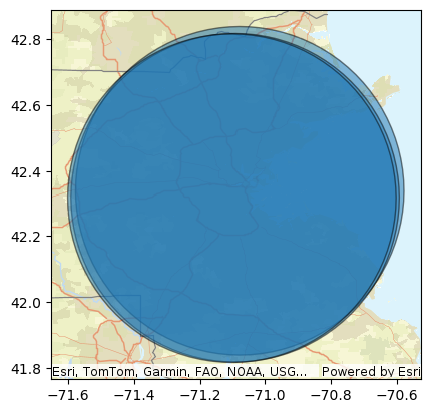

In [22]:
# plot the buffer calculated in degrees
df_schools.st.plot(basemap="streets", geometry="geometry_buffer", alpha=0.5, edgecolor="black")

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 24, Finished, Available, Finished)

<Axes: >

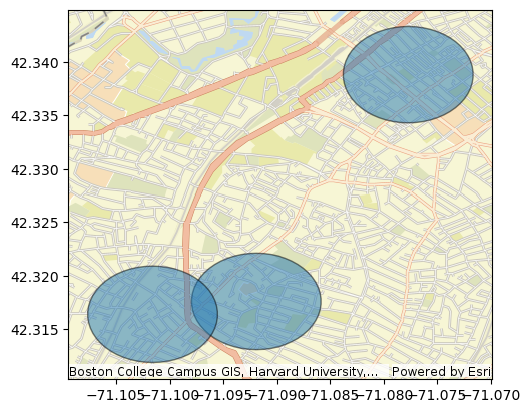

In [23]:
# plot the geodesic buffer calculated in meters
df_schools.st.plot(basemap="streets", geometry="geometry_geodesic_buffer", alpha=0.5, edgecolor="black")

There are a few key things to notice when plotting these buffers: 
* The buffers in the first plot look huge, while the buffers in the second are much smaller.  The "geometry_buffer" is half a decimal degree, while the "geometry_geodesic_buffer" is just 500 meters.  One decimal degree is significantly longer than 500 meters.  At the equator, a degree of latitude or longitude is close to 111 miles!
* The buffers in the first plot ("geometry_buffer") look circular while the buffers in the second plot ("geometry_geodesic_buffer") look like ovals.  Why is this?  Both of these maps are generated on a map based on the latitude and longitude coordinates.  In these plots, one degree of latitude is equal to one degree of longitude in length.  On the earth, the length of one degree of latitude and longitude differ, with a degree of longitude becoming a shorter and shorter length as you get closer to the poles. The Wikipedia entry on [Longitude](https://en.wikipedia.org/wiki/Longitude) discusses this in nice detail if you would like more information.   When the geodesic buffers are plotted on this particular map projection, they appear stretched out into ovals, though, on the earth's surface they would be circular.


If we were to plot the geodesic buffer in our local Boston coordinate system (SRID 2249), the buffers look like the circles that we would expect.  

We can update the map when we plot it by adding an `sr` (spatial reference) parameter.  The cell below demonstrates this. More information on the paramters for `st.plot` can be found in the [API reference](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#plot).

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 25, Finished, Available, Finished)

<Axes: >

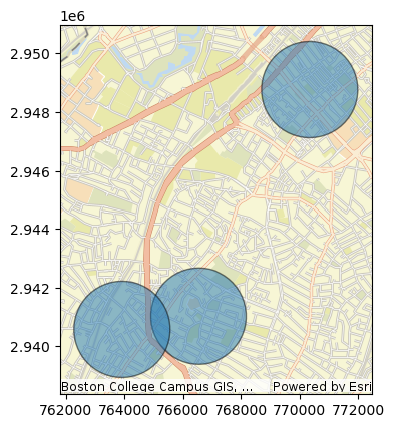

In [24]:
# plotting the geometry_geodesic_buffer on a map with spatial reference of 2249
df_schools\
    .st.plot(basemap="streets", geometry="geometry_geodesic_buffer", alpha=0.5, edgecolor="black", sr=2249)

In general, it is faster to run [ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/) vs. [ST_GeodesicBuffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_buffer/) as the buffers are calculated using planar coordinates instead of geodesic coordinates.  However, this means that you should select an appropriate local coordinate system prior to using [ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/).

For example, we can translate the latitude and longitude-based points to a local coordinate system like the Massachusetts State Plane Coordinate System (SRID: 2249) and then create our buffers.  We can do this using the [ST_Transform](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_transform/) function as part of the buffer creation.

When transforming data between coordinate systems, it is important to know the units that are used.  In this case, the units are feet.  You can look this up with a web site like [SpatialReference.org](https://spatialreference.org/). Here is the entry for [SRID 2249](https://spatialreference.org/ref/epsg/2249/)


In [25]:
# create 500 foot buffers around the school coordinates using a local coordinate system
df_schools = df_schools\
    .withColumn("geometry_buffer_2249", ST.buffer(ST.transform("geometry", 2249), 500))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 26, Finished, Available, Finished)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 27, Finished, Available, Finished)

<Axes: >

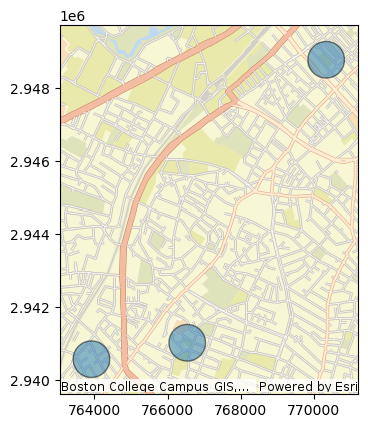

In [26]:
# plot the buffer calculated in feet
df_schools.st.plot(basemap="streets", geometry="geometry_buffer_2249", alpha=0.5, edgecolor="black")

As an example for how to use these buffers, they could then be used to identify exactly which service requests were in the local area near each school using a spatial intersection

In [27]:
# list the service requests near to each school
# the service requests are identified by joining the two tables to identify where 
# the service request geometry is inside the school buffer
display(
    df.join(df_schools.drop("geometry"), ST.contains("geometry_geodesic_buffer", "geometry"))\
        .select("dateTime", "category", "subcategory", "status", "address", "name")\
        .sort("name")
    )

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 28, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1e82184b-6920-4995-a6d7-b6e4340f8744)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 29, Finished, Available, Finished)

<Axes: >

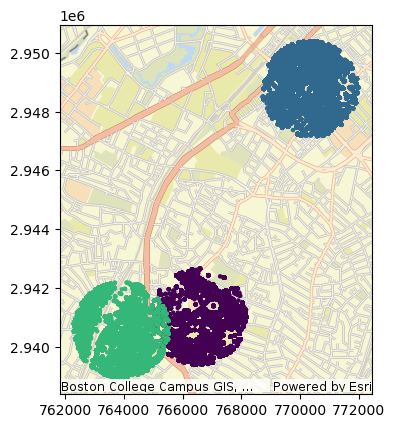

In [28]:
# plot the results and color code the service requests based on which school they are near
df.join(df_schools.drop("geometry"), ST.contains("geometry_geodesic_buffer", "geometry"))\
    .st.plot(basemap="streets", geometry="geometry", marker_size=5, cmap_values="name")

#### Aggregation with Bin functions

With large point datasets where many features overlap, grouping the features into a polygon bin (e.g., square, hexagon, or administrative polygon like a Census tract) with aggregated attributes (e.g., count of features in the bin, average value for an attribute, etc.) can help in simplifying and visualizing patterns.

GeoAnalytics includes three methods for spatial binning:
* [ST_HexBin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_hex_bin/)
* [ST_H3Bin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_h3_bin/) - [H3 bins](https://h3geo.org/)
* [ST_SquareBin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_square_bin/)

In this notebook, we will just look at one example, but there are more details on the range of spatial binning capabilities with GeoAnalytics for Fabric in the [developer documentation](https://developers.arcgis.com/geoanalytics-fabric/).

##### Identifying a bin for each record
In this example, we'll look at the [ST_H3Bin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_h3_bin/) function to identify the [H3 bin](https://h3geo.org/) that each point is inside.  We will then use a PySpark [GroupBy](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html) function to make a simplified DataFrame that lists the count of points inside each bin.

The size of H3 bins is based on a resolution value.  For this example, we will use a resolution of 8, which equates to an average hexagonal bin size of 0.73 square kilometers.  More information on [H3 bin resolutions can be found here](https://h3geo.org/docs/core-library/restable)

In [29]:
df = df\
    .withColumn("h3_bin", ST.h3_bin("geometry", 8))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 30, Finished, Available, Finished)

The [ST_H3Bin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_h3_bin/) function adds a _bin id_ to each record. It doesn't add the geometry specifically, as there would be many duplicates of the geometry (one for each point inside the bin) and it is more efficient to work with the ID until we need the geometries for analysis or visualization. 

In [30]:
display(
    df.select("dateTime", "category", "subcategory", "status", "address", "geometry", "h3_bin")
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 31, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a0262741-d2f9-4b5b-9f8e-b7269525e6f3)

Using the `h3_bin` ID field, we can then group the values in our table to count the records in each bin.

In [31]:
# group the service requests DataFrame using the h3 bin ID and count all records
df_by_bin = df.groupBy("h3_bin").count()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 32, Finished, Available, Finished)

In [32]:
# view the result with the counts per bin
display(df_by_bin)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 33, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ab19f004-cf8c-4456-bdfc-d1769831a350)

In [33]:
# add the bin geometry based on the bin ID using ST_BinGeometry
df_by_bin = df_by_bin\
    .withColumn("geometry_bin", ST.bin_geometry("h3_bin"))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 34, Finished, Available, Finished)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 35, Finished, Available, Finished)

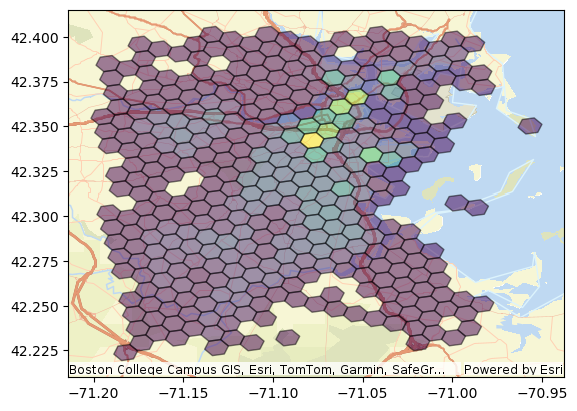

In [34]:
# plot the bins to visualize the results; color the bins based on the count of points inside each bin
myplt = df_by_bin.st.plot(basemap="streets", geometry="geometry_bin", cmap_values="count", edgecolor="black", alpha=0.5)

#### ST_ShortestLine and ST_GeodesicLine

[ST_ShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_shortest_line/) returns a linestring column representing the shortest line that touches two geometries, using planar distance calculation.  This function returns only one shortest line if there are more than one that can be calculated between locations.

To create a shortest line using geodesic distance calculations, use [ST_GeodesicShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_shortest_line/)

As an example of this, we will look at the shortest line between the schools DataFrame that we created earlier and the service requests that are nearby.  Shortest line will use two geometry columns as input, so they need to be in the _same_ DataFrame.  

In the buffer examples above, we used [ST_Contains](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_contains/) to find all of the points inside the buffer polygon. 

In this example, we will use another spatial calculation called [ST_DWithin](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_dwithin/) (distance within) to find all points within a specified distance of the school points.  Effectively this can give the same result, however DWithin is often more performant than creating a buffer and performing a spatial join.  DWithin uses planar calculations by default, so we should either transform the geometry into a local coordinate system, or set the parameter to use geodesic calculations.

In this case, we will use [ST_Transform](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_transform/) to update the coordinate system for this calculation.



In [35]:
# find all points within 500 feet of each school 
# use a spatial join to match any point that is within the specified distance of the school
# since the datasets are originally in latitude/longitude coordinates, we transform to a local coordinate system first 
df_schools_requests = df.join(df_schools.select("name", F.col("geometry").alias("geometry_school")), 
    ST.dwithin(ST.transform("geometry", 2249), ST.transform("geometry_school", 2249), 500))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 36, Finished, Available, Finished)

In [36]:
# calculate the shortest line from each point to each school
df_schools_requests = df_schools_requests\
    .withColumn("geometry_line", ST.shortest_line("geometry", "geometry_school"))

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 37, Finished, Available, Finished)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 38, Finished, Available, Finished)

<Axes: >

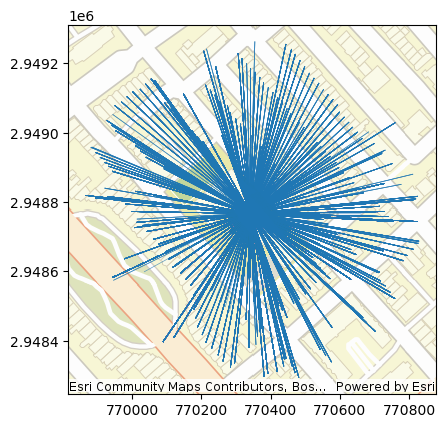

In [37]:
# plot the connector lines between one school and all of the points within 500 feet of this location
df_schools_requests.filter(F.col("name") == "Hurley K-8").st.plot(basemap="streets", geometry="geometry_line", linewidth=0.5, alpha=0.7)

For short distances, [ST_ShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_shortest_line/) is a good choice, but for longer distances, you might consider using [ST_GeodesicShortestLine](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_shortest_line/) so that the line that is created represents the shortest path on the sphere.  As an example of the difference between the "shortest line" (planar calculation) and the geodesic line, we can explore the difference between a line connected between Los Angeles and London.  In this example, the geodesic line (orange) appears curved and longer in this projection, but it is actually the shortest line!

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 39, Finished, Available, Finished)

<Axes: >

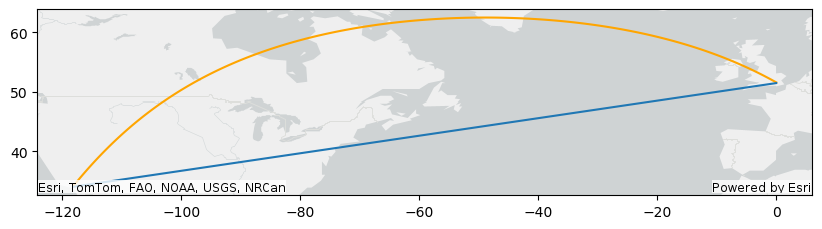

In [38]:
# geodesic line (geodesic) (in orange) vs. "shortest line" (planar) (in blue)
# the geodesic line appears curved and longer in this projection, but it is actually the shortest line!

# create points for two locations
data = [
    ("POINT (-118.2426 34.0549 )", "Los Angeles", 
     "POINT (0.1276 51.5072 )", "London")
]

# create a DataFrame with the two locations
# convert the locations from well-known text to geometry
df_lines = spark.createDataFrame(data, ["wkt-origin", "city-origin", "wkt-dest", "city-dest"])\
          .select("city-origin", 
                  "city-dest", 
                  ST.geom_from_text("wkt-origin", 4326).alias("geometry-origin"), 
                  ST.geom_from_text("wkt-dest", 4326).alias("geometry-dest"))


# plot the results to compare the two lines generated (geodesic vs. shortest)
myplt = df_lines.select(ST.geodesic_shortest_line("geometry-origin", "geometry-dest")).st.plot(basemap="light", figsize=(10,10), color="orange")
df_lines.select(ST.shortest_line("geometry-origin", "geometry-dest")).st.plot(ax=myplt)

### Accessing properties of geometry 
The GeoAnalytics library contains a set of accessor functions for calculating properties of geometry, such as:


We will explore a subset of these functions:

* [ST_Area](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_area/), [ST_GeodesicArea](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_area/)
* [ST_Distance](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_distance/), [ST_GeodesicDistance](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_distance/)
* [ST_Length](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_length/), [ST_GeodesicLength](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_length/)


#### ST_Area and ST_GeodesicArea

[ST_Area](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_area/) - calculates a planar area for each geometry. The unit of the area is the same as the input geometries.  If you calculate area on a dataset in a geographic coordinate system, the units will be square decimal degrees. This is not a recommended unit.  For using the ST_Area function it is best to use a projected coordinate system.  More information is available in the [Coordinate Systems and Transformations core concept document](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/).

[ST_GeodesicArea](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_area/) calculates area for each geometry in square meters, and requires that a spatial reference is set on the input geometry column.

For this example, we will calculate areas for US states that we read in from an ArcGIS feature service.

In [39]:
# US states feature service from the Esri Living Atlas of the World
# For more information on this dataset: https://www.arcgis.com/home/item.html?id=774019f31f8549c39b5c72f149bbe74e
fs_url = "https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Census_States/FeatureServer/0"

df_states = spark.read.format('feature-service').load(fs_url)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 40, Finished, Available, Finished)

After reading in the feature service, we can take a look at the data to see what is included

In [40]:
display(df_states)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, be25f44b-03db-47c1-b577-fa4d9cde74e6)

Before calculating the area, we can check the coordinate system so that we know more about the units that are used in the coordinate system and decide if we are going to use [ST_Area](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_area/) or [ST_GeodesicArea](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_area/)

In [41]:
df_states.st.get_spatial_reference()

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 42, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

Let's look at the values calculated by [ST_Area](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_area/) and [ST_GeodesicArea](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_area/).

In the example below we display the original data for the state name and square miles, and three new calculated fields, all rounded to two decimal places for readability using PySpark [Round()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.round.html)
* area using ST_Area - since the spatial reference is 4326 with a unit of Degree, the results will be in square decimal degrees, which has no real applicable value
* area using ST_Area on a _transformed_ geometry using USA Contiguous Albers Equal Area projection (102003).  This calculation returns square meters, so they have been converted to square miles
* area using ST_GeodesicArea on the original geometry.  This calculation returns square meters, so they have been converted to square miles


The values returned are all very close to one another in value, but not exactly the same. These deviations are due to distortion in calculation of area for large regions (the [Coordinate Systems and Transformations core concept document](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/) provides more information on distortion in projections), as well as minor variations in precision that can be introduced with the projection and transformation process.


In [42]:
# When reading feature services, the geometry is generally in a column named "Shape."  This can be confirmed by looking at the displayed table above
display(
    df_states.select("STATE_NAME", 
                     "SQMI", 
                     F.round(ST.area("Shape"), 2).alias("Area (sq decimal degrees"), 
                     F.round(ST.area(ST.transform("Shape", 102003))/2.59e+6, 2).alias("Area (sqmi)"), 
                     F.round(ST.geodesic_area("Shape")/2.59e+6, 2).alias("GeodesicArea (sqmi)")
                     )
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 43, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 753c54e2-20cc-4352-b9db-80031f4ec6ea)

#### Distance and Length calculations

* [ST_Distance](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_distance/) and [ST_GeodesicDistance](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_distance/) will calculate the distance between two input locations.  The unit for ST_Distance is the same as the input geometries.  For ST_GeodesicDistance the distance is calculated in meters.
* [ST_Length](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_length/) and [ST_GeodesicLength](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geodesic_length/) will calculate the length of an input feature.  The unit for ST_Length is the same as the input geometry.  For ST_GeodesicLength the length is calculated in meters.

We will take a look at these calculations using the lines that we generated earlier connecting school locations to the service requests that are nearby.

With the distance calculation, we can also look at a particularly nice feature of the GeoAnalytics library - projection on the fly.  If you want to calculate a property or relationship using two geometries that are in _different_ coordinate systems, the library can often reconcile this difference for you so that you don't need to transform the data.

* The `geometry` column is in the Massachusetts State Plane coordinate system (SRID 2249)
* The `geometry_schools` column is in WGS84 latitude and longitude (SRID 4326)


In [43]:
# check the spatial reference for "geometry"
df_schools_requests.st.get_spatial_reference("geometry")

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 44, Finished, Available, Finished)

SpatialReference(srid=2249, is_projected=True, unit='US Survey Foot', wkt='PROJCS["NAD_1983_StatePlane_Massachusetts_Mainland_FIPS_2001_Feet",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",656166.6666666665],PARAMETER["False_Northing",2460625.0],PARAMETER["Central_Meridian",-71.5],PARAMETER["Standard_Parallel_1",41.71666666666667],PARAMETER["Standard_Parallel_2",42.68333333333333],PARAMETER["Latitude_Of_Origin",41.0],UNIT["Foot_US",0.3048006096012192]]')

In [44]:
# check the spatial reference for "geometry_school"
df_schools_requests.st.get_spatial_reference("geometry_school")

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 45, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

Now we will calculate a variety of distance calculations and see how GeoAnalytics can work with geometries in different coordinate systems!  In the cell below we are calculating:

* Distance between the two geometries without transforming the coordinates
* Distance between the two geometries with a transformation to convert the `geometry_school` to Massachusetts State Plane (2249) 
* Geodesic distance between the two geometries without a transformation

We will also calculate the length of the line `geometry_line` that we created earlier to connect the two point locations

In [45]:
display(
    df_schools_requests.select("geometry", 
                            "geometry_school", 
                            F.round(ST.distance("geometry", "geometry_school"), 2).alias("Distance (no transform)"),
                            F.round(ST.distance("geometry", ST.transform("geometry_school", 2249)),2).alias("Distance (transform)"),
                            F.round(ST.geodesic_distance("geometry", "geometry_school"),2).alias("GeodesicDistance (meters)"),
                            "geometry_line",
                            F.round(ST.length("geometry_line"),2).alias("Length (feet)"),
                            F.round(ST.geodesic_length("geometry_line"),2).alias("GeodesicLength (meters)")
                            )
)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 46, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1e8c8d5e-474f-41e4-a080-ebb23fab944d)

StatementMeta(, d72f5a1a-c1d0-4800-99a9-84ae1836b704, 47, Finished, Available, Finished)

<Axes: >

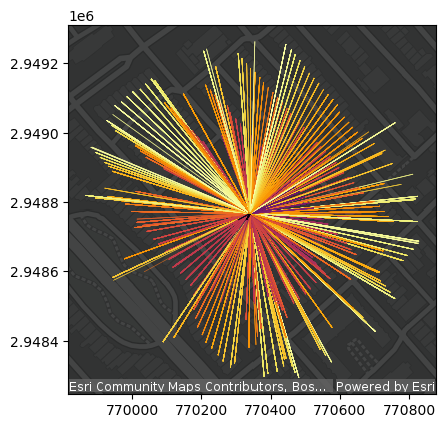

In [46]:
# plot the length results and color encode based on length  
df_schools_requests.filter(F.col("name") == "Hurley K-8")\
    .select("geometry_line", ST.distance("geometry", "geometry_school").alias("length"))\
    .st.plot(basemap="dark", geometry="geometry_line", cmap_values="length", linewidth=0.5, alpha=0.7, cmap="inferno")

# Summary
In this sample notebook, we have explored how the GeoAnalytics for Microsoft Fabric library can help you:
* Read data and construct point geometries from latitude and longitude
* Convert between geometry types
* Set and update coordinate reference information
* Create new geometries such as buffers 
* Calculate properties for geometries 

There are more than 160 [spatial functions](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/) in the GeoAnalytics Library and this is just a small set of the capabilities.  For more details on what is included in the library, check out the [developer documentation](https://developers.arcgis.com/geoanalytics-fabric/).